# Superstore API
Time series predictions for the Superstore dataset.

## Goal
Predict sales amount for a given time frame.

# Model Selection
This notebook covers the predictive model selection.

## Imports
This notebook requires the following packages. Make sure you have them installed in order to use this notebook.

In [17]:
import datetime

import pandas as pd
import statsmodels as sm

## Default variables
Define default variables for the notebook.

In [2]:
ROOT_FOLDER = os.path.split(os.getcwd()[:-1])[0]
PROCESSED_DATA_FOLDER = os.path.join(ROOT_FOLDER, "data", "processed")

## Load data
The dataset is in the `data\processed` folder.

In [3]:
DATASET_FILE_NAME = "dataset.csv"

data = pd.read_csv(
    os.path.join(PROCESSED_DATA_FOLDER, DATASET_FILE_NAME), 
    index_col="Order Date",
    parse_dates=["Order Date"],
    )
print(f"Number of rows = {data.shape[0]}")
data.head()

Number of rows = 1237


,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,4407.100
2014-01-07,87.158


Check visually.

<AxesSubplot:xlabel='Order Date'>

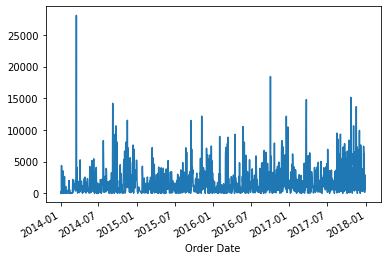

In [4]:
data["Sales"].plot()

## Split Data

In [24]:
YEAR_DELTA = datetime.timedelta(days=365)
split_point = data.index.max() - YEAR_DELTA

train = data[data.index <= split_point]
test = data[data.index > split_point]

## Modelling
### Autoregression (AR)

### Moving Average (MA)

### Autoregressive Moving Average (ARMA)

### Autoregressive Integrated Moving Average (ARIMA)

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

### Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX)

### Vector Autoregression (VAR)

### Vector Autoregression Moving-Average (VARMA)

### Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)

### Simple Exponential Smoothing (SES)

### Holt Winter’s Exponential Smoothing (HWES)